In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4 as nc
import seaborn as sns
import matplotlib.colors as mcolors
import glob
import os
import xarray as xr
import cmocean
import datetime
from salishsea_tools import viz_tools, tidetools, geo_tools, gsw_calls, wind_tools
import pickle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import h5py
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>

<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
SOG350highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_01may16/04jan20-11jan20/currents.hdf5', 'r')
SOG350lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_02aug17/04jan20-11jan20/currents.hdf5', 'r')
SOG150highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_08may17/04jan20-11jan20/currents.hdf5', 'r')
SOG150lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_10nov17/04jan20-11jan20/currents.hdf5', 'r')

In [3]:
zeroc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/zero_winds/04jan20-11jan20/currents.hdf5', 'r')

In [4]:
TP350highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_20nov17/04jan20-11jan20/currents.hdf5', 'r')
TP350lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_31may18/04jan20-11jan20/currents.hdf5', 'r')
TP150highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_17nov15/04jan20-11jan20/currents.hdf5', 'r')
TP150lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/currents.hdf5', 'r')

SB350highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_26dec16/04jan20-11jan20/currents.hdf5', 'r')
## reusing TP forcing files because for wind event
SB350lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/currents.hdf5', 'r')
SB150highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_26jun16/04jan20-11jan20/currents.hdf5', 'r')
SB150lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SB/fakewinds_02aug18/04jan20-11jan20/currents.hdf5', 'r')

## reusing TP and SOG forcing files because for wind events
BP350highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/SOG/fakewinds_01may16/04jan20-11jan20/currents.hdf5', 'r')
BP350lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_13oct18/04jan20-11jan20/currents.hdf5', 'r')
BP150highc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/TP/fakewinds_20nov17/04jan20-11jan20/currents.hdf5', 'r')
BP150lowc = h5py.File('/ocean/vdo/MIDOSS/mohid-forcing/BP/fakewinds_19jul15/04jan20-11jan20/currents.hdf5', 'r')

In [5]:
def make_plot(cfile, yind, xind, ymax, ymin, xmax, xmin):  
    SOGc3 = np.zeros((168, 396, 896))
    SOGv3 = np.zeros((168, 396, 896))
    SOGu3 = np.zeros((168, 396, 896))
    t = 0
    for keyU, keyV in zip(list(SOG350highc['Results']['velocity U'].keys())[:168], list(SOG350highc['Results']['velocity V'].keys())[:168]):
        SOGc3[t, :] = np.sqrt(np.square(cfile['Results']['velocity U'][keyU][-1,:]) 
                                       + np.square(cfile['Results']['velocity V'][keyV][-1,:]))
        SOGu3[t, :] = cfile['Results']['velocity U'][keyU][-1,:]
        SOGv3[t, :] = cfile['Results']['velocity V'][keyV][-1,:]
        t = t + 1

    fig, ax = plt.subplots(1, 3, figsize = (15, 10))
    ax[0].set_title('u velocities')
    ax[1].set_title('v velocities')
    ax[2].set_title('current speed')
    ax[0].pcolormesh(np.ma.masked_equal(np.average(SOGu3, axis = 0).T,0), vmin = -2, vmax = 2, cmap = cmocean.cm.balance)
    ax[1].pcolormesh(np.ma.masked_equal(np.average(SOGv3, axis = 0).T,0), vmin = -2, vmax = 2, cmap = cmocean.cm.balance)
    mesh = ax[2].pcolormesh(np.ma.masked_equal(np.average(SOGc3, axis = 0).T,0), vmin = -2, vmax = 2, cmap = cmocean.cm.balance)
    q = ax[2].quiver(np.arange(0, 396, 1)[::10], np.arange(0, 896, 1)[::10],
                     np.ma.masked_equal(np.average(SOGu3, axis = 0).T,0)[::10, ::10], 
                     np.ma.masked_equal(np.average(SOGv3, axis = 0).T,0)[::10, ::10], scale = 5)
    ax[2].quiverkey(q,0.1, 0.1, 1, r'$1 \frac{m}{s}$', labelpos='E')
    for a in ax:
        a.plot(xind, yind, 'ro')
        a.set_ylim(ymin, ymax)
        a.set_xlim(xmin, xmax)
        viz_tools.set_aspect(a)
    p0 = ax[0].get_position().get_points().flatten()
    p1 = ax[1].get_position().get_points().flatten()
    p2 = ax[2].get_position().get_points().flatten()

    ax_cbar = fig.add_axes([p0[0], 0.2, p2[2], 0.05]) 
    cbar = plt.colorbar(mesh, cax=ax_cbar, orientation='horizontal')

# SOG 350 high

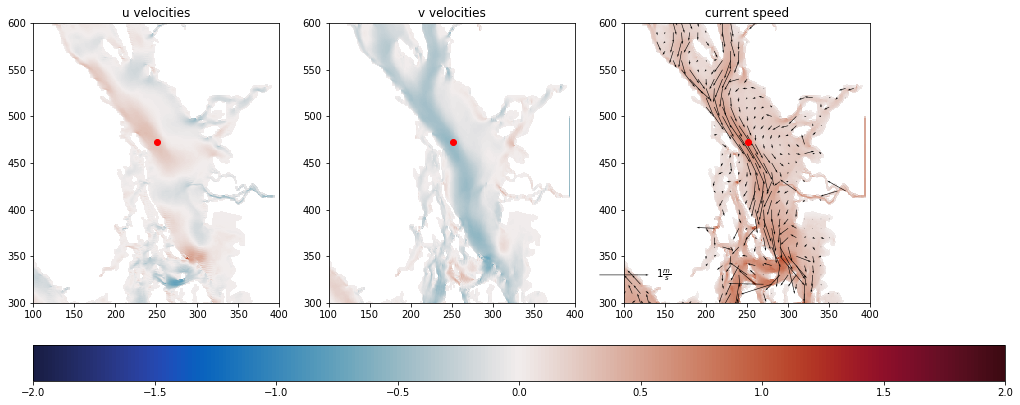

In [6]:
make_plot(SOG350highc, 473, 251, 600, 300, 400, 100)

# SOG 350 low

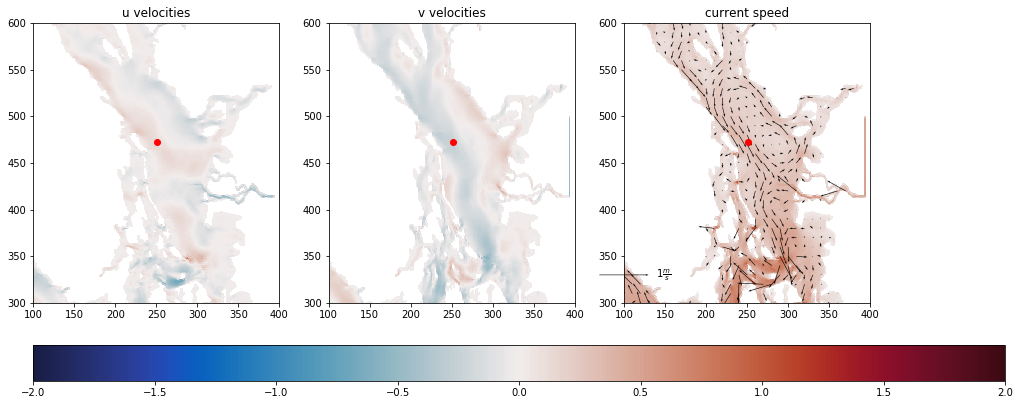

In [7]:
make_plot(SOG350lowc, 473, 251, 600, 300, 400, 100)

# SOG 150 high

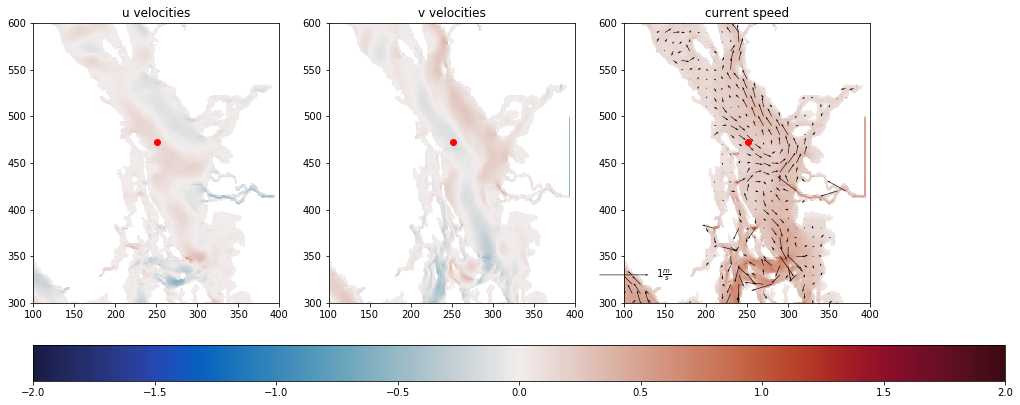

In [8]:
make_plot(SOG150highc, 473, 251, 600, 300, 400, 100)

# SOG 150 low

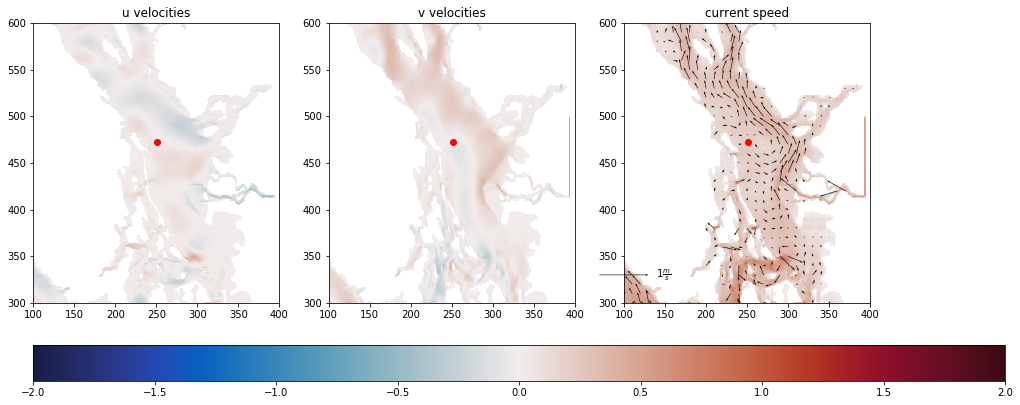

In [9]:
make_plot(SOG150lowc, 473, 251, 600, 300, 400, 100)

# SOG zero

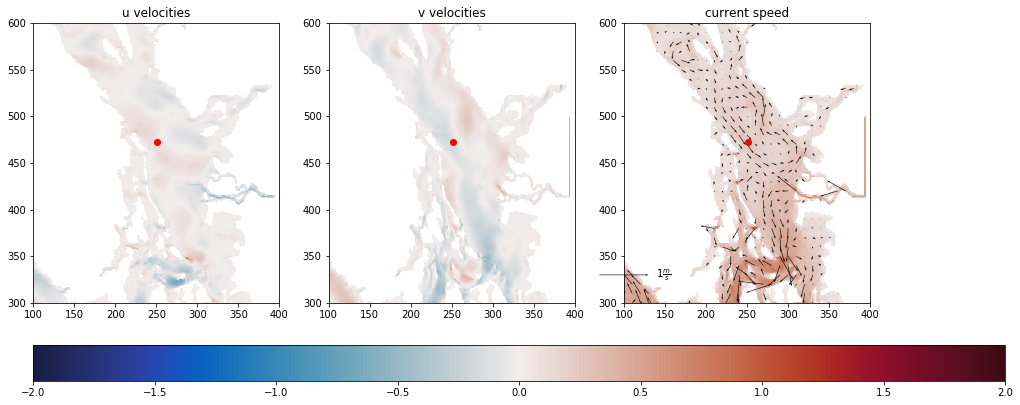

In [10]:
make_plot(zeroc, 473, 251, 600, 300, 400, 100)

# TP 100 high

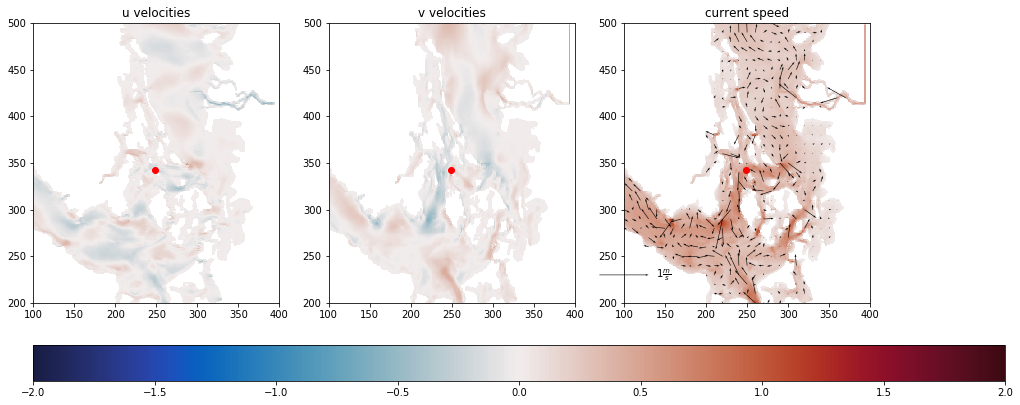

In [11]:
make_plot(TP350highc, 342, 249, 500, 200, 400, 100)

# TP 100 low

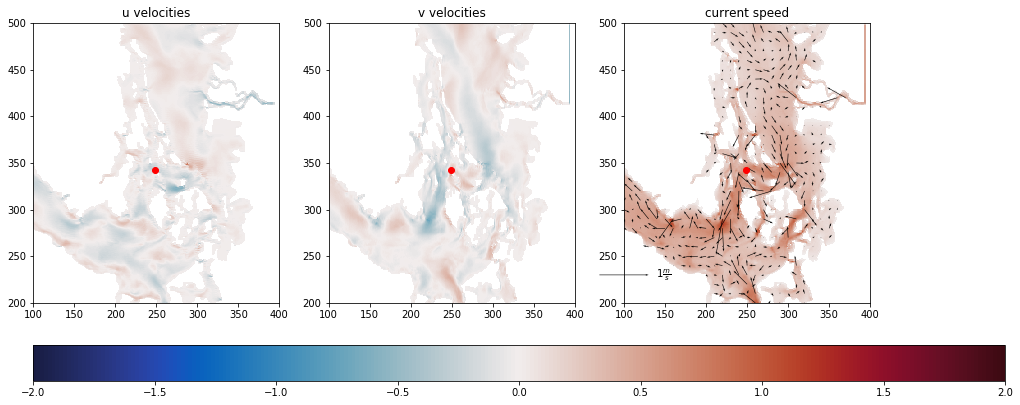

In [12]:
make_plot(TP350lowc, 342, 249, 500, 200, 400, 100)

# TP 270 high

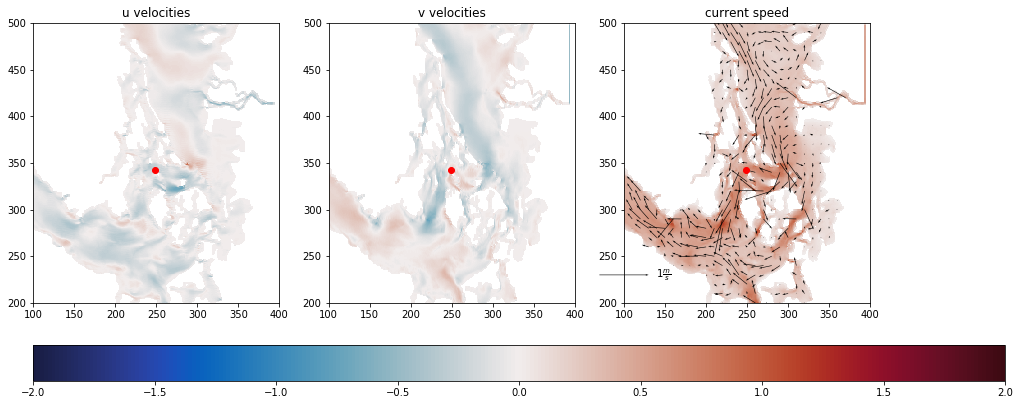

In [13]:
make_plot(TP150highc, 342, 249, 500, 200, 400, 100)

# TP 270 low

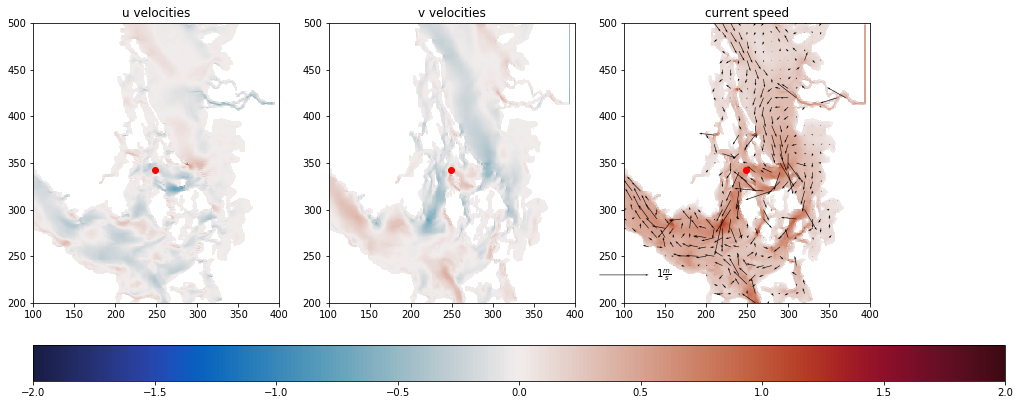

In [14]:
make_plot(TP150lowc, 342, 249, 500, 200, 400, 100)

# TP zero

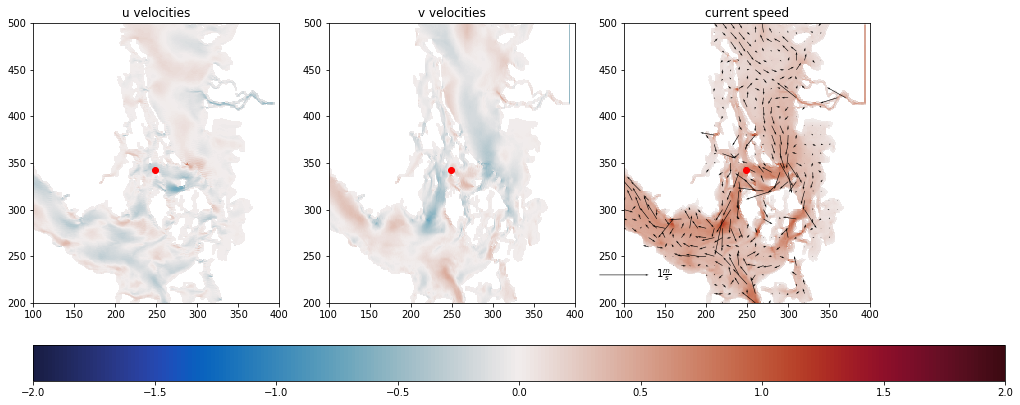

In [15]:
make_plot(zeroc, 342, 249, 500, 200, 400, 100)

# SB 200 high

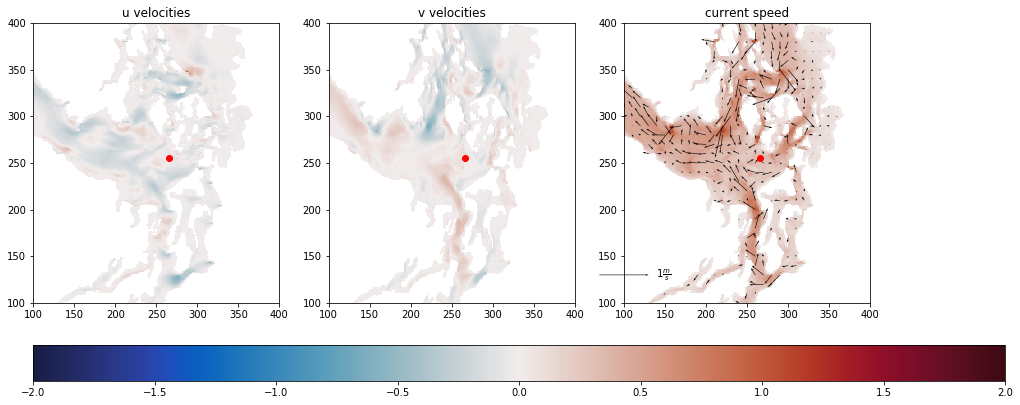

In [16]:
make_plot(SB350highc, 255, 266, 400,100, 400, 100)

# SB 200 low

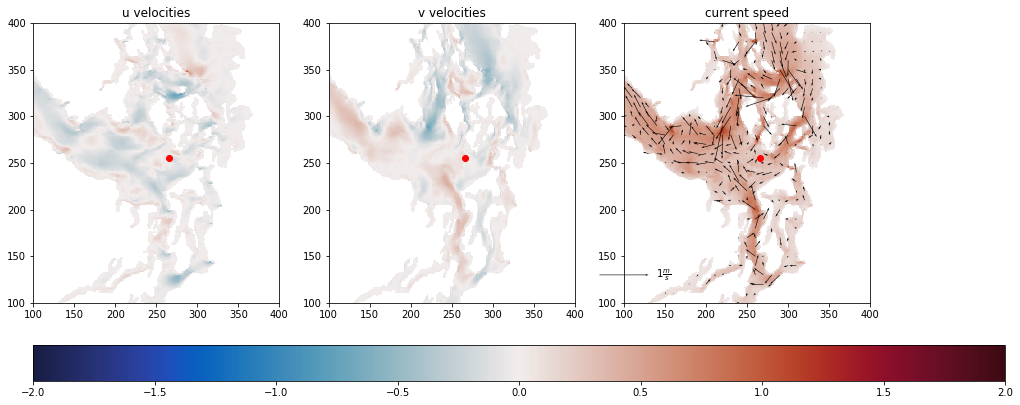

In [17]:
make_plot(SB350lowc, 255, 266, 400, 100, 400, 100)

# SB 60 high

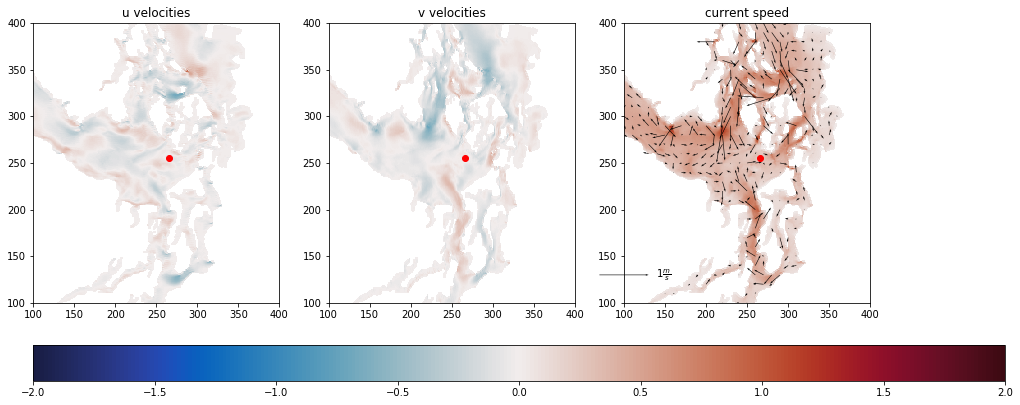

In [18]:
make_plot(SB150highc, 255, 266, 400, 100, 400, 100)

# SB 60 low

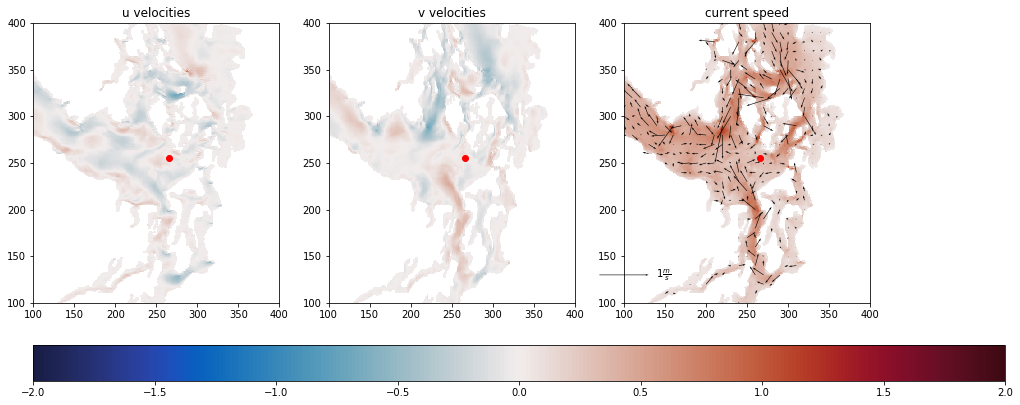

In [19]:
make_plot(SB150lowc, 255, 266, 400, 100, 400, 100)

# SB zero

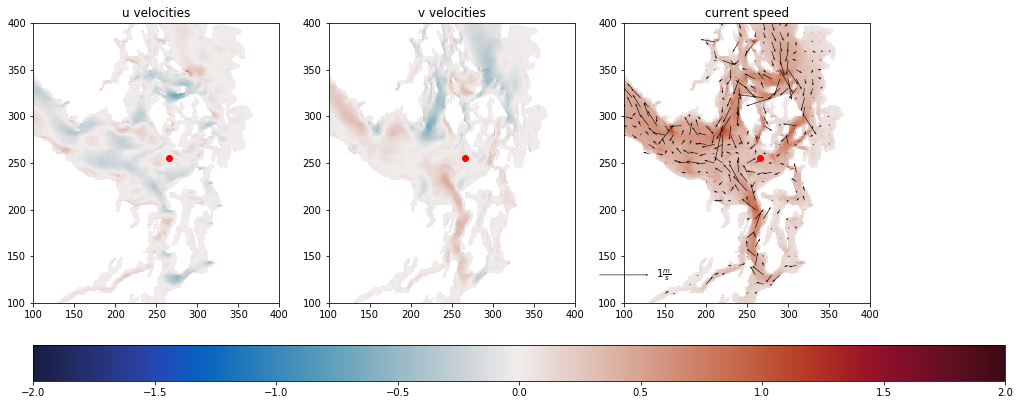

In [20]:
make_plot(zeroc, 255, 266, 400, 100, 400, 100)

# BP 260 high

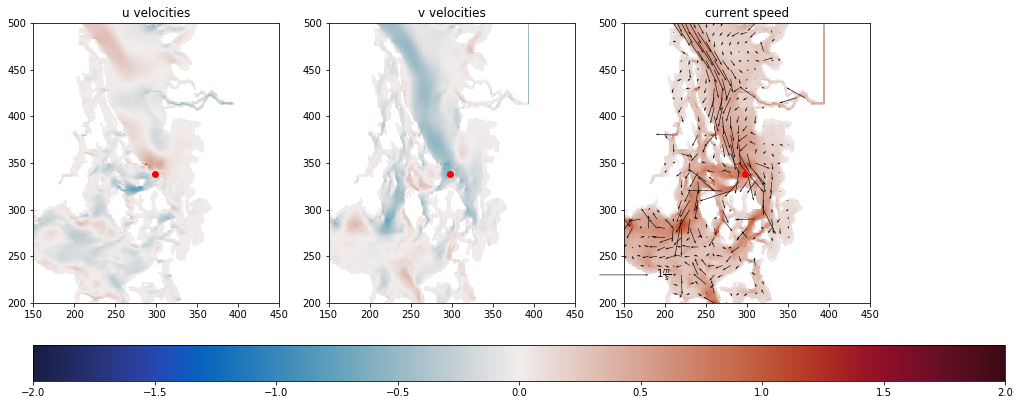

In [21]:
make_plot(BP350highc, 338, 298, 500, 200, 450, 150)

# BP 260 low

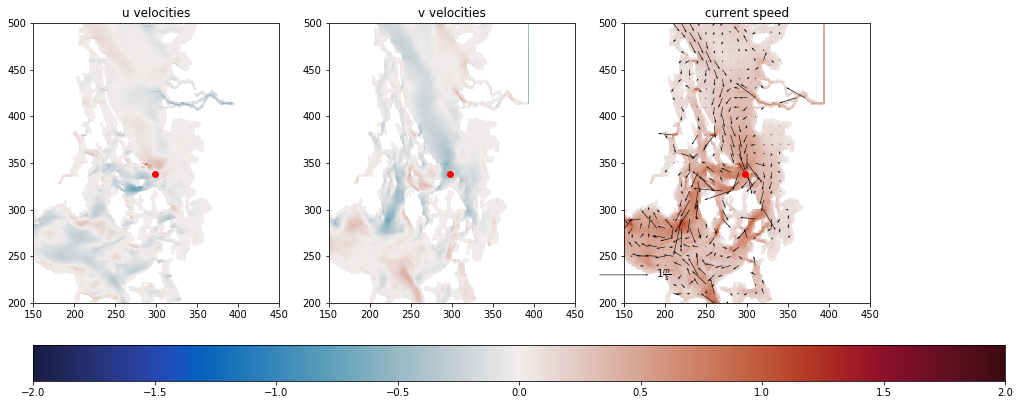

In [22]:
make_plot(BP350lowc, 338, 298, 500, 200, 450, 150)

# BP 100 high

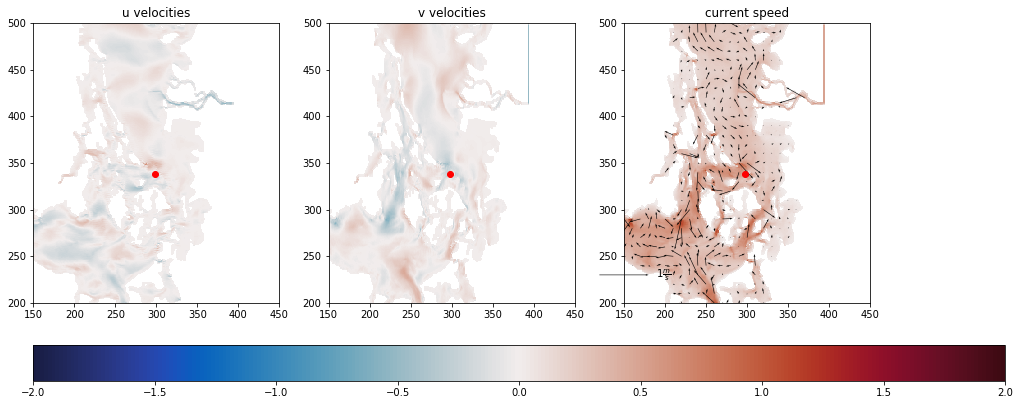

In [23]:
make_plot(BP150highc, 338, 298, 500, 200, 450, 150)

# BP 100 low

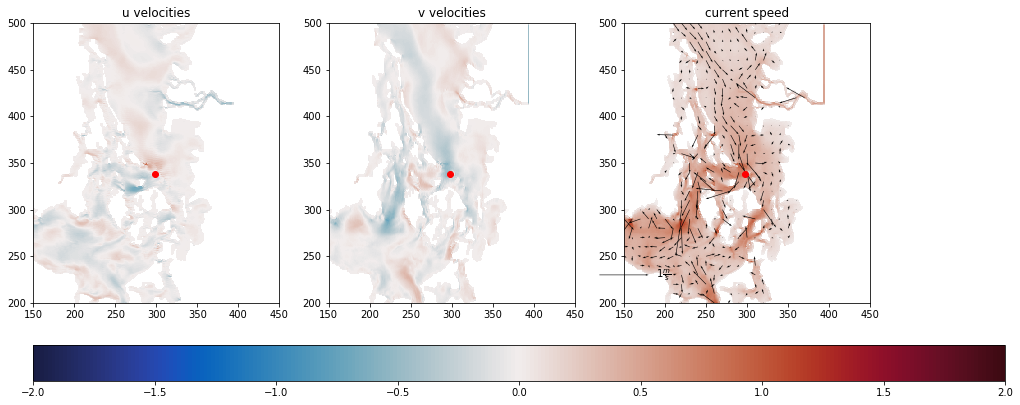

In [24]:
make_plot(BP150lowc, 338, 298, 500, 200, 450, 150)

# BP zero

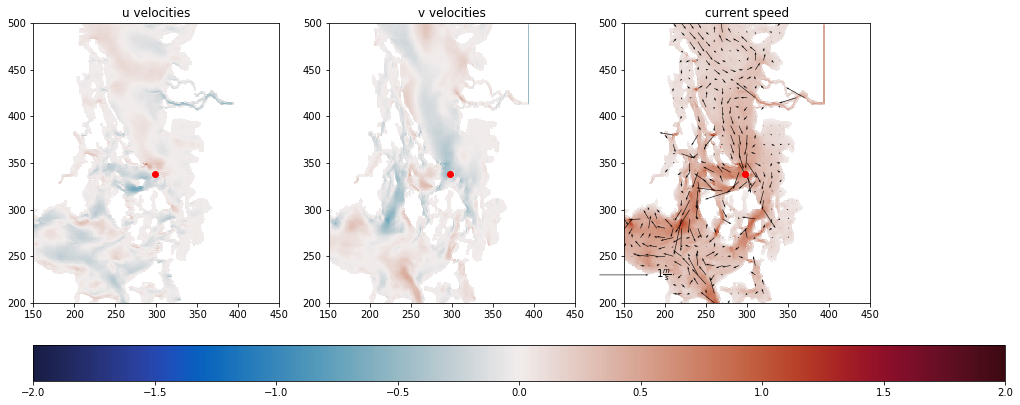

In [25]:
make_plot(zeroc, 338, 298, 500, 200, 450, 150)